In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os

# Visualizing 3D Data

In [3]:
def read_off(file_path):
    with open(file_path, 'r') as file:
        # Read the header
        header = file.readline().strip()
        if header != 'OFF':
            raise ValueError('Not a valid OFF file')

        # Read number of vertices, faces, and edges
        n_verts, n_faces, _ = map(int, file.readline().strip().split())

        # Read vertex coordinates
        vertices = []
        for _ in range(n_verts):
            vertex = list(map(float, file.readline().strip().split()))
            vertices.append(vertex)
        vertices = np.array(vertices)

        # Read faces (index of vertices)
        faces = []
        for _ in range(n_faces):
            face_info = list(map(int, file.readline().strip().split()))
            face = face_info[1:]  # Ignore the first number (number of vertices in the face)
            faces.append(face)
        faces = np.array(faces)

        # Center the model: subtract the centroid of the vertices
    centroid = np.mean(vertices, axis=0)
    vertices -= centroid

    # Normalize the size: scale vertices to fit within a unit sphere
    max_distance = np.max(np.linalg.norm(vertices, axis=1))
    vertices /= max_distance

    return vertices, faces


In [4]:
def visualize_model(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection object
    mesh = Poly3DCollection(vertices[faces], alpha=0.5)
    
    # Add the collection to the axes
    ax.add_collection3d(mesh)

    # Set limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Auto scale to the mesh size
    scale = vertices.flatten()
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()

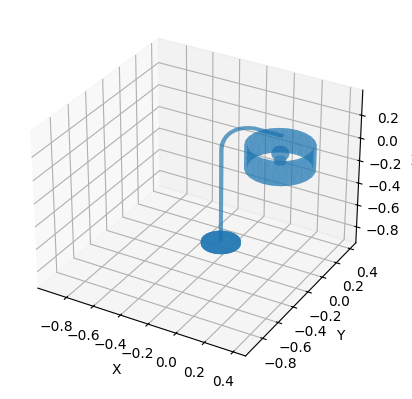

In [22]:
label = "lamp"
n = "0002"
model = f"./ModelNet40/{label}/train/{label}_{n}.off"

vertices, faces = read_off(model)
visualize_model(vertices, faces)

# Visualizing 2D sketches

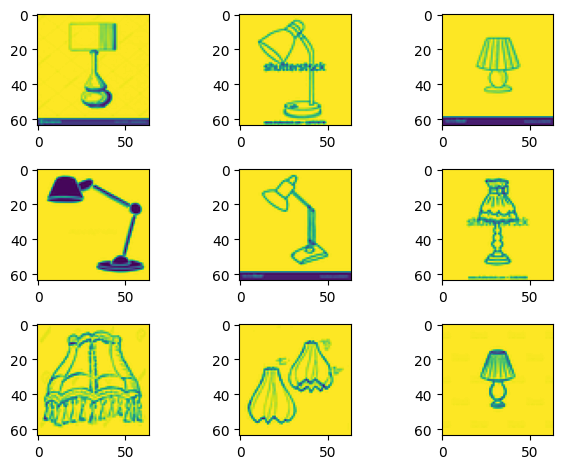

In [6]:
from PIL import Image

label = "lamp"

pth = f"ImageNetSketchMini/{label}/"
fls = os.listdir(pth)
s = 10

for i in range(s, s+9):
    im_pth = pth + fls[i]
    img = Image.open(im_pth)
    img = img.convert('L')
    img = img.resize((64, 64), Image.Resampling.LANCZOS)
    img = np.array(img)
    plt.subplot(3, 3, i-s+1)
    plt.imshow(img)

plt.tight_layout()
plt.show()

- Stairs
- Baththub
- Merge bed/sofa
- desk
- 

# Model to 3d Voxel Grid

In [19]:
from scipy.spatial import cKDTree

def read_off_to_voxels(file_path, grid_size=32):
    with open(file_path, 'r') as file:
        # Read the header
        header = file.readline().strip()
        if header != 'OFF':
            raise ValueError('Not a valid OFF file')

        # Read number of vertices, faces, and edges
        n_verts, n_faces, _ = map(int, file.readline().strip().split())

        # Read vertex coordinates
        vertices = []
        for _ in range(n_verts):
            vertex = list(map(float, file.readline().strip().split()))
            vertices.append(vertex)
        vertices = np.array(vertices)

        # Read faces (index of vertices)
        faces = []
        for _ in range(n_faces):
            face_info = list(map(int, file.readline().strip().split()))
            face = face_info[1:]  # Ignore the first number (number of vertices in the face)
            faces.append(face)
        faces = np.array(faces)

    # Center the model: subtract the centroid of the vertices
    centroid = np.mean(vertices, axis=0)
    vertices -= centroid

    # Normalize the size: scale vertices to fit within a unit sphere
    max_distance = np.max(np.linalg.norm(vertices, axis=1))
    vertices /= max_distance

    # Convert the 3D model to a voxel grid
    # Step 1: Scale the vertices to fit within the grid size
    scaled_vertices = (vertices + 1) * (grid_size - 1) / 2  # Scale to [0, grid_size - 1]
    scaled_vertices = scaled_vertices.astype(int)  # Convert to integers

    # Step 2: Create an empty voxel grid
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)

    # Step 3: Fill the voxel grid based on the vertex positions
    # Using a KD-Tree to check proximity and fill neighboring voxels for "surface"
    tree = cKDTree(scaled_vertices)
    for vertex in scaled_vertices:
        voxel_grid[vertex[0], vertex[1], vertex[2]] = 1

    return voxel_grid


In [20]:
array3d = read_off_to_voxels(model, 32)
array3d.shape

(32, 32, 32)

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_voxel_grid(voxel_grid):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get the x, y, z coordinates of the non-zero (filled) voxels
    filled = np.argwhere(voxel_grid == 1)

    # Plot the filled voxels
    ax.scatter(filled[:, 0], filled[:, 1], filled[:, 2], zdir='z', c='red', marker='o')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()


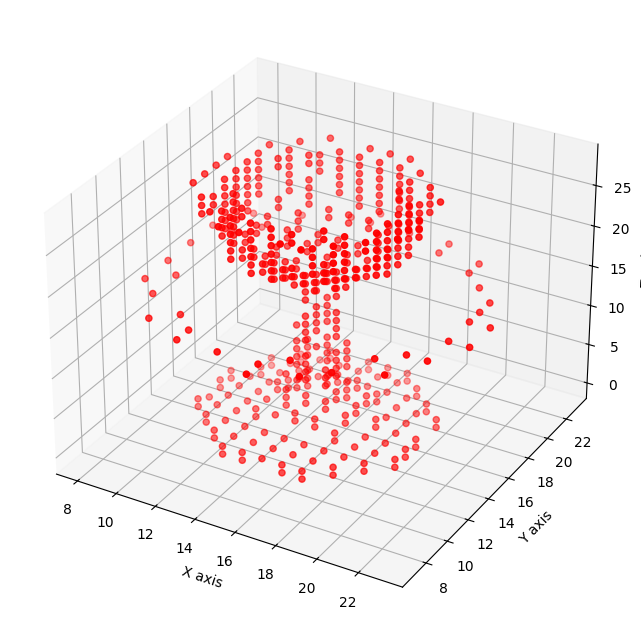

In [10]:
plot_voxel_grid(array3d)

In [12]:
import numpy as np

def read_off_to_pointcloud(file_path, num_points=1024):
    # Read the OFF file
    with open(file_path, 'r') as file:
        # Read the header
        header = file.readline().strip()
        if header != 'OFF':
            raise ValueError('Not a valid OFF file')

        # Read number of vertices, faces, and edges
        n_verts, n_faces, _ = map(int, file.readline().strip().split())

        # Read vertex coordinates
        vertices = []
        for _ in range(n_verts):
            vertex = list(map(float, file.readline().strip().split()))
            vertices.append(vertex)
        vertices = np.array(vertices)

        # Center the model: subtract the centroid of the vertices
        centroid = np.mean(vertices, axis=0)
        vertices -= centroid

        # Normalize the size: scale vertices to fit within a unit sphere
        max_distance = np.max(np.linalg.norm(vertices, axis=1))
        vertices /= max_distance

    # Downsample or pad the point cloud to a fixed number of points (e.g., 1024)
    if len(vertices) > num_points:
        # Randomly sample points if there are more points than `num_points`
        idx = np.random.choice(len(vertices), num_points, replace=False)
        pointcloud = vertices[idx]
    else:
        # Pad with zeros if there are fewer points than `num_points`
        pointcloud = np.zeros((num_points, 3))
        pointcloud[:len(vertices)] = vertices

    return pointcloud

cloud = read_off_to_pointcloud(model, 2000)

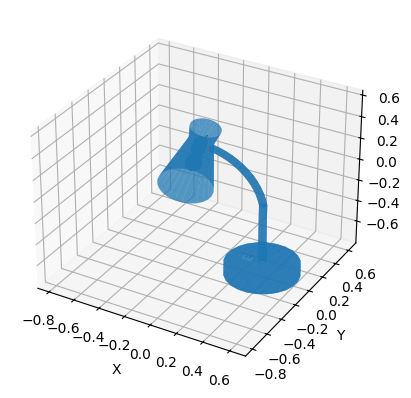

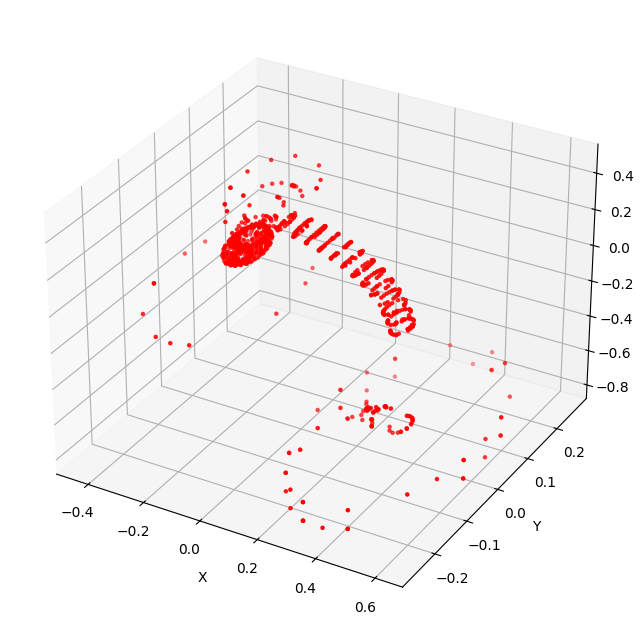

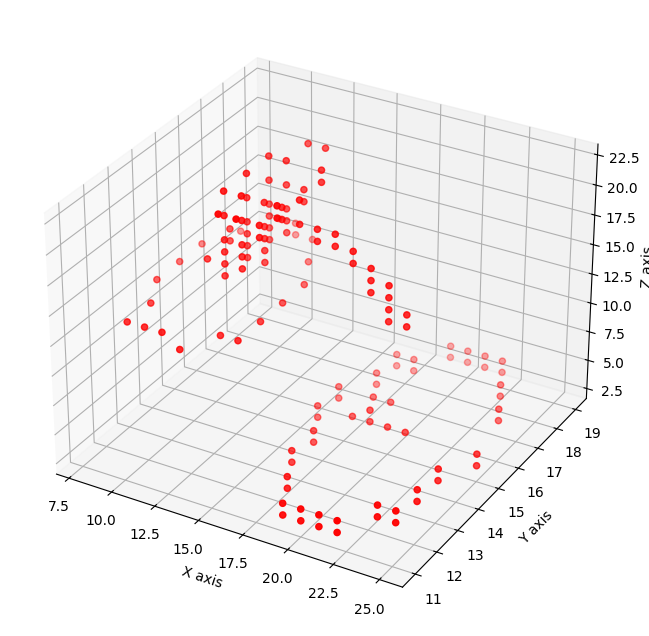

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

label = "lamp"
n = "0003"
model = f"./ModelNet40/{label}/train/{label}_{n}.off"

vertices, faces = read_off(model)
visualize_model(vertices, faces)

cloud = read_off_to_pointcloud(model, 1024)

def plot_pointcloud(pointcloud):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the point cloud
    ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], c='r', marker='o', s=5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Plot the point cloud
plot_pointcloud(cloud)
array3d = read_off_to_voxels(model, 32)
array3d.shape
plot_voxel_grid(array3d)



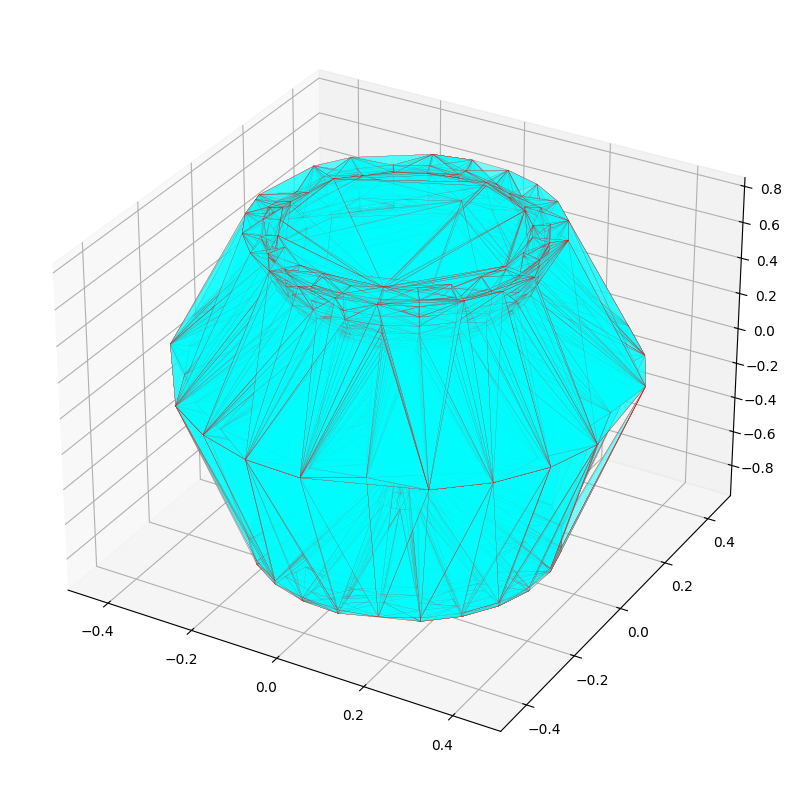

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def pointcloud_to_mesh_delaunay(pointcloud):
    # Perform Delaunay triangulation
    tri = Delaunay(pointcloud)
    
    # Extract vertices (points) and faces (triangles)
    verts = pointcloud
    faces = tri.simplices

    return verts, faces

def plot_mesh(verts, faces):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate the triangular mesh
    mesh = Poly3DCollection(verts[faces], facecolors='cyan', linewidths=0.1, edgecolors='r', alpha=0.3)
    ax.add_collection3d(mesh)

    # Set limits based on the vertices' extents
    ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
    ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
    ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())

    plt.show()

# Example usage with point cloud
pointcloud = cloud  # Replace with your actual point cloud
verts, faces = pointcloud_to_mesh_delaunay(pointcloud)
plot_mesh(verts, faces)


2024-10-17 11:07:43.166 (   0.267s) [    7F53544AF740]      vtkDelaunay3D.cxx:513   WARN| vtkDelaunay3D (0x563251d72a90): 2 degenerate triangles encountered, mesh quality suspect
/home/achraf/anaconda3/envs/py310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


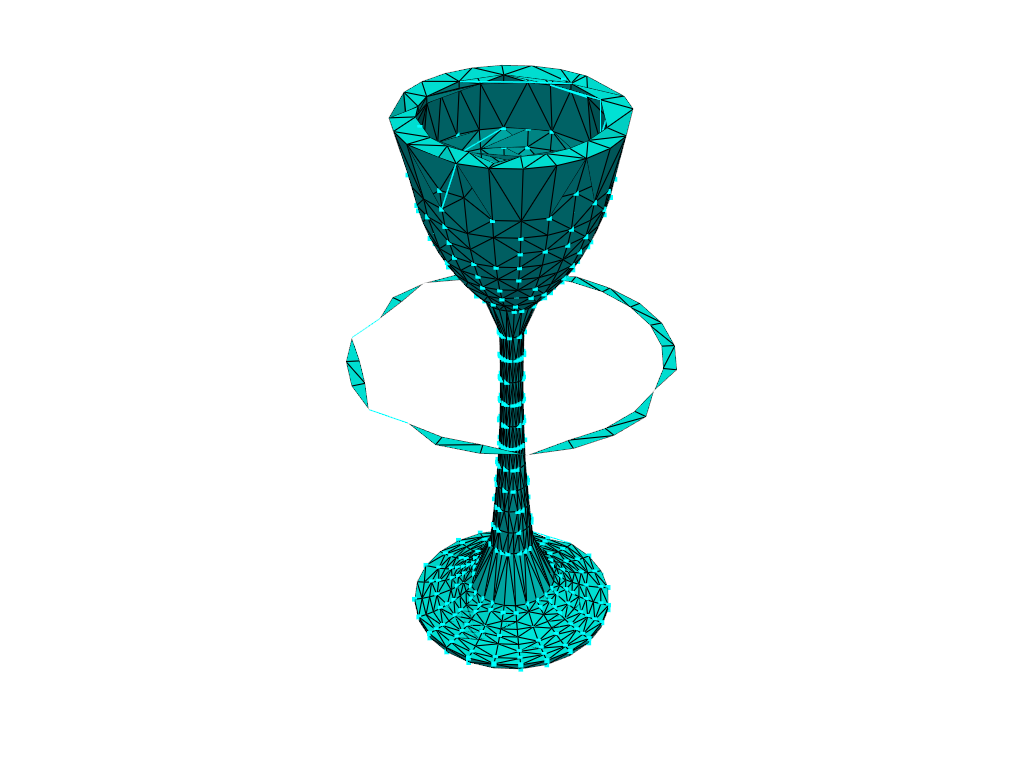

In [14]:
import numpy as np
import pyvista as pv
from scipy.spatial import Delaunay

def pointcloud_to_alpha_shape(pointcloud, alpha=1.0):
    # Create a pyvista point cloud
    cloud = pv.PolyData(pointcloud)

    # Perform alpha shape reconstruction
    surface = cloud.delaunay_3d(alpha=alpha)

    return surface

def plot_alpha_shape(surface):
    plotter = pv.Plotter()
    plotter.add_mesh(surface, color="cyan", show_edges=True)
    plotter.show()

# Example usage with point cloud
pointcloud = cloud  # Replace with your actual point cloud
surface = pointcloud_to_alpha_shape(pointcloud, alpha=0.1)
plot_alpha_shape(surface)


In [15]:
import open3d as o3d
import numpy as np

# Create a point cloud with Open3D
pcd = o3d.geometry.PointCloud()

# Set the points of the point cloud
pointcloud = cloud  # Replace with your actual point cloud
pcd.points = o3d.utility.Vector3dVector(pointcloud)

# Estimate normals for the point cloud (required for Poisson reconstruction)
pcd.estimate_normals()

# Perform Poisson Surface Reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=16)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


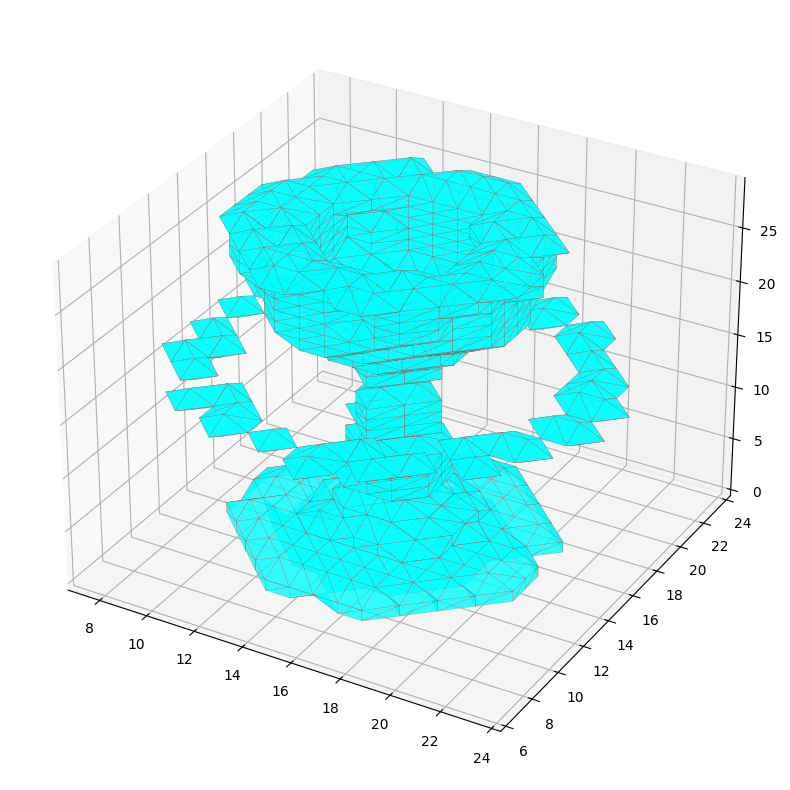

In [38]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def voxel_to_mesh_marching_cubes(voxel_grid):
    # Apply Marching Cubes to the voxel grid to get vertices and faces
    verts, faces, normals, _ = measure.marching_cubes(voxel_grid, level=0)

    return verts, faces

def plot_mesh(verts, faces):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate the triangular mesh
    mesh = Poly3DCollection(verts[faces], facecolors='cyan', linewidths=0.1, edgecolors='r', alpha=0.8)
    ax.add_collection3d(mesh)

    # Set limits based on the vertices' extents
    ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
    ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
    ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())

    plt.show()

# Example usage
voxel_grid = array3d  # Replace with your actual voxel grid
verts, faces = voxel_to_mesh_marching_cubes(voxel_grid)
plot_mesh(verts, faces)


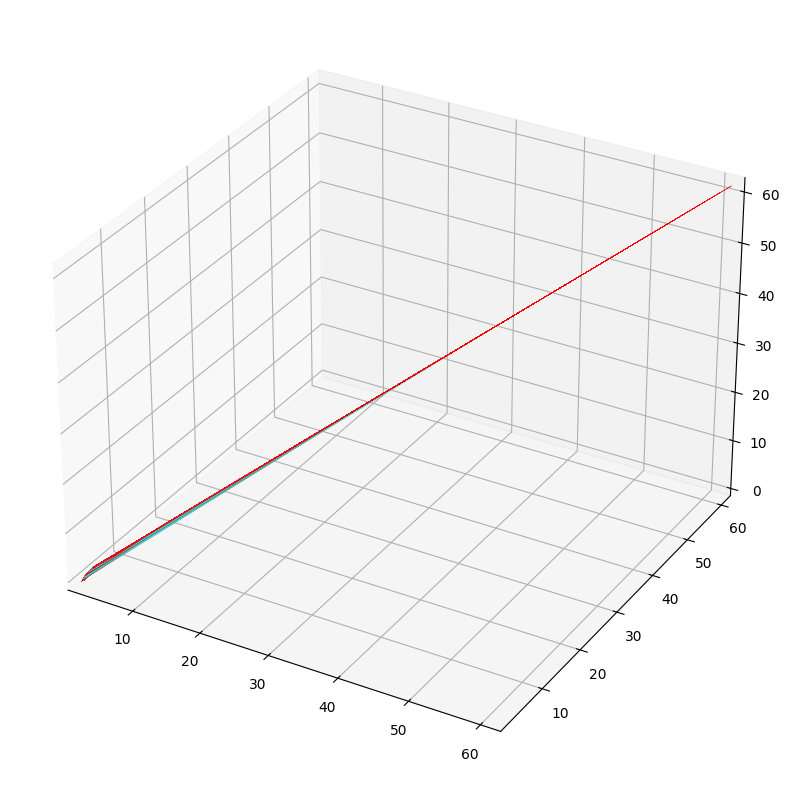

In [50]:
import numpy as np
import mcubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# mcubes.smooth


def voxel_to_mesh_surface_nets(voxel_grid):
    # Apply Surface Nets to the voxel grid to get vertices and faces
    verts, faces = mcubes.marching_cubes(voxel_grid, 0)
    verts = mcubes.smooth(verts)

    return verts, faces

def plot_mesh(verts, faces):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate the triangular mesh
    mesh = Poly3DCollection(verts[faces], facecolors='cyan', linewidths=0.1, edgecolors='r', alpha=0.8)
    ax.add_collection3d(mesh)

    # Set limits based on the vertices' extents
    ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
    ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
    ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())

    plt.show()

# Example usage with Surface Nets
voxel_grid = array3d  # Replace with your actual voxel grid
verts, faces = voxel_to_mesh_surface_nets(voxel_grid)
plot_mesh(verts, faces)


Keys: <KeysViewHDF5 ['images', 'labels']>


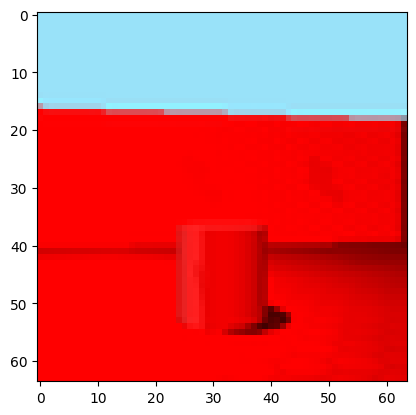

In [7]:
import h5py
import matplotlib.pyplot as plt

# Open the HDF5 file in read mode
with h5py.File('3dshapes.h5', 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    
    # Accessing a dataset
    dataset = file['images']
    # print(dataset[0])  # Print all elements of the dataset
    plt.imshow(dataset[20])
    plt.show()